In [1]:
# imports
import math
import numpy as np
import itertools as it
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

# Initialize

In [2]:
# set up demo graph
n = 6
G_A = nx.Graph()
Ef_A = nx.Graph()
P_A = nx.complete_graph(range(1,n+1))
#
G_A.add_nodes_from(range(1,n+1))
Ef_A.add_nodes_from(range(1,n+1))
print(G_A.nodes)
G_A.add_edges_from(((4,5),(3,2),(4,3),(5,2),(6,4),(1,5),(1,2)))
e1 = (5,4)
e2 = (4,5)
f1 = e1 in P_A.edges()
f2 = e2 in P_A.edges()

print(f1)
print(f2)
#P_A.remove_edge(*e)
#f1 = e in P_A.edges()
#print(f1)

#display



[1, 2, 3, 4, 5, 6]
True
True


# Algorithm 1: DegreeDiffElim

In [3]:
def DegreeDiffElim(G_A,P_A,kA):
    edges = list(P_A.edges())
    for e in edges:
        if abs(G_A.degree(e[0]) - G_A.degree(e[1])) > kA:
            P_A.remove_edge(*e)
    return P_A

# Algorithm 2: FixedDegElim

In [4]:
def FixedDegElim(G_A,P_A,Ef_A):
    edges = list(P_A.edges())
    for e in edges:
        if Ef_A.degree(e[0]) > G_A.degree(e[1]):
            P_A.remove_edge(*e)
    return P_A

# Algorithm 3: Helper Functions

In [5]:
# check independence 
#
def vertex_independent_from(v,i,j,G_A):
    edge,Ni,Nj = pair2neighborhood(G_A,1,2)
    _i = edge[0]
    _j = edge[1]
    #print(Ni)
    #print(f"Neighborhood of {_i} is {Ni}")
    #for _ni in nx.neighbors(G_A,_i):
        #print(_ni)
    #print(f"Neighborhood of {_j} is {Nj}")
    #for _nj in nx.neighbors(G_A,_j):
        #print(_nj)

    #print("------")
    niUnj = Ni | Nj
    #for _e in niUnj:print(_e)

    #print(f"Ni union Nj: {niUnj}")
    Nv = set(nx.neighbors(G_A,v))
    #print(f"Neighborhood of v: {Nv}")
    _intersection = niUnj.intersection(Nv) 
    #print(f"Intersection of Nv and Ni U Nj: {_intersection}")
    #print(_intersection)
    return not bool(_intersection)

In [6]:
# larger neighborhood should be Ni (line 6 in DKAS)
# larger neighborhood should be on left
def sortByLength(set1,set2):
    if len(set1) == len(set2):
        return set1, set2
    elif len(set1) > len(set2):
        return set1, set2
    else:
        return set2,set1

In [7]:
# mostly as written in DASG paper
# page 8, lines 10-20
def assign_weight_k1(i,j,Ni,Nj,G_A,P_A):
    e = (i,j)
    if i == j:
        return 0
    if e in P_A.edges():
        if G_A.degree(i) > G_A.degree(j) and vertex_independent_from(i,Ni,Nj,G_A):
            print(f"{e} is in FIRST 1 clause")
            return -2*(G_A.degree(i) - G_A.degree(j))
        elif G_A.degree(j) > G_A.degree(i) and vertex_independent_from(j,Ni,Nj,G_A):
            print(f"{e} is in SECOND 2 clause")
            return -2*(G_A.degree(j) - G_A.degree(i))
        else:
            vertex_independent_from(i,Ni,Nj,G_A)
            print(f"{e} is in THIRD 3 clause")
            print(f" degree of {j} = {G_A.degree(j)}")
            print(f" degree of {i} = {G_A.degree(i)}")
            return -abs(G_A.degree(i) - G_A.degree(j))
    else:
        return -math.inf

In [8]:
# this is for d2v and v2d
def assign_weight_k2(neighbor,dummy_parent,Ef_A):
    edge = (neighbor,dummy_parent)
    if edge in Ef_A.edges():
        return -math.inf
    else: return -2

In [9]:
# returns python set of integers, sorted by length
def pair2neighborhood(g,i,j):
    N_i = set((e for e in nx.neighbors(g,i)))
    N_j = set((f for f in nx.neighbors(g,j)))
    #print("1: neighbors")
    #print(N_i)
    #print(N_j)
    #eliminate_this_logic!!!!!!!!!!!!!!!!
    #try:
    #    N_i.remove(j)
    #    N_j.remove(i)
    #except(ValueError,TypeError,KeyError):
    #    print("")
    Ni,Nj = sortByLength(N_i,N_j)
    if g.degree(i) < g.degree(j):
        _i = j
        _j = i
    else:
        # no exchange
        _i = i
        _j = j
    #print(f"2: remove {i} or {j}")
    #print(Ni)
    #print(Nj)
    #remove duplicates
    #duplicates = Ni.intersection(Nj)
    #for d in duplicates:
    #    Ni.remove(d)
    #    Nj.remove(d)
    #print(f"3: remove duplicates: {duplicates}")
    #print(Ni)
    #print(Nj)
    edge = (_i,_j)
    return edge, Ni,Nj

### Algorithm 3: Build Cost Matrix

In [10]:
# build-cost-matrix using python set
def BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A):
    _edge, _Ni_int,_Nj_int = pair2neighborhood(G_A,i,j)
# initialize    
    CostMatrix = nx.Graph()
    degDiff = abs(G_A.degree(i) - G_A.degree(j))
    Ni = []
    Nj = []
    xi = []
    xj = []
    # swap j and i in order to consistently refer to larger set on left
    #if G_A.degree(i) < G_A.degree(j):
    #    _i = j
    #    _j = i
    #else:
        # no exchange
    #    _i = i
    #    _j = j
    _i = _edge[0]
    _j = _edge[1]
# make vertices
##
## dummy: used for edge deletion
## parent: used in weight assignment logic
## value: used in updating permutation graph
##
    for e in _Ni_int:
        name = "i" + str(e)
        Ni.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=False,parent=_i,value=e)
    for f in _Nj_int:
        name = "j" + str(f)
        Nj.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=False,parent=_j,value=f)
        
    print(f"vertices for Ni: {Ni}")
    print(f"vertices for Nj: {Nj}")
    
# # larger set xi goes in right partition of graph as indicated by 'bipartite' parameter
    for xe in range(1,degDiff+k_A+1):
        name = "xi" + str(xe)
        xi.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=True,parent=_i,value=_i)
    for xf in range(1,k_A+1):
        name = "xj" + str(xf)
        xj.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=True,parent=_j,value=_j)
        
    print(f"xi: {xi}")
    print(f"xj: {xj}")
    
# make edges (weights negated)
    value = nx.get_node_attributes(CostMatrix,'value') # used for permutation graph update
    parent = nx.get_node_attributes(CostMatrix,'parent') # used for weight assignment
# # vertex to vertex
    V2V = []
    for e0 in it.product(Ni,Nj):
        weight = assign_weight_k1(value[e0[0]],value[e0[1]],_Ni_int,_Nj_int,G_A,P_A)
        #print(f" vertex to vertex (Ni cross Nj): {e0} ;weight: {weight}")
        V2V.append((*e0,weight))
        
# # vertex to dummy
    D2V = []
# # #"draw an edge between vj and xj"
    for e1 in it.product(xj,Nj):
        weight = assign_weight_k2(value[e1[1]],parent[e1[0]],Ef_A)
        #print(f" dummy to vertex (xj cross Nj): {e1} ;weight: {weight}")
        D2V.append((*e1,weight))
    
    V2D = []
# # #"draw an edge between ui and xi"
    for e2 in it.product(Ni,xi):
        weight = assign_weight_k2(value[e2[0]],parent[e2[1]],Ef_A)
        #print(f" vertex to dummy (Ni cross xi): {e2} ;weight: {weight}")
        D2V.append((*e2,weight))

# # dummy to dummy
    D2D = []
    for e3 in it.product(xj,xi):
        #print(f"dummy to dummy {e3}")
        D2D.append((*e3,0))

# add weighted edges
    CostMatrix.add_weighted_edges_from(V2V)
    CostMatrix.add_weighted_edges_from(D2V)
    CostMatrix.add_weighted_edges_from(V2D)
    CostMatrix.add_weighted_edges_from(D2D)
# display
    #l,r = bipartite.sets(CostMatrix)
    #print(f"bipartite.sets left set {l}")
    #print(f"bipartite.sets right set {r}")
    return CostMatrix 

# HungarianSolve: find cost perfect matching

In [11]:
# 
# draw bipartite graph
#
def plot_cost_matrix(CostMatrix):
    l,r = bipartite.sets(CostMatrix)
    pos = dict()
    pos.update( (nn, (1, ii)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
    pos.update( (nn, (2, ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
    nx.draw(CostMatrix, pos=pos,with_labels=True)
    ##edge weights
    labels = nx.get_edge_attributes(CostMatrix, "weight")
    nx.draw_networkx_edge_labels(CostMatrix, pos=pos, edge_labels=labels)
    print("edge weights")
    for w in labels:
        print(f"edge: {w} -- weight: {labels[w]}")
    plt.show()
    

In [12]:
# HungarianSolve from page 9 of detect-almost-symmetries
# calculates the sum of the weights in the matching
def HungarianSolve(CostMatrix):
    cost = 0
    deleteEdges = []
    #
    # draw bipartite graph
    #
    plot_cost_matrix(CostMatrix)
    
    #
    # Solve Cost Perfect Matching problem
    #
    Matching = nx.max_weight_matching(CostMatrix,maxcardinality=True)
    print(f"is perfect matching: {nx.is_perfect_matching(CostMatrix,Matching)}")
    print(f"MATCHING: {Matching}")
    
    #
    # node properties (dictionary)
    #
    dummy = nx.get_node_attributes(CostMatrix,"dummy")
    value = nx.get_node_attributes(CostMatrix,"value")
    
    #
    # for each pair in optimal assignment, extract edges which correspond to edge deletions, and sum the cost. 
    #
    for m in Matching:
        i = m[0]
        j = m[1]
        #
        #
        # 'ui is dummy T/F?' XOR 'j is dummy T/F?'
        #
        # "From the solution we determine when an edge {ui, xi} or {vj, xj}
        # is in the optimal assignment. The former corresponds to the deletion of edge {i, u} in
        # GA, the later to the deletion of edge {j, v}."
        #
        if dummy[i] ^ dummy[j]:
            print(f"encoded edge: {m}")
            print(f"value dict conversion: value[i] = {value[i]}, value[j] = {value[j]}")
            #
            # update cost, deleteEdges
            # cost multiplied by -1 here.
            deleteEdges.append((value[i],value[j]))
        cost +=-1*CostMatrix[i][j]['weight']
            
    return cost,deleteEdges

# Refine By Matching

In [13]:
#
def RefineByMatching(G_A,P_A,Ef_A,k_A):
    #
    edgeUse = {}
    for e in G_A.edges():
        print("G_A edges: ",e)
        edgeUse[e] = 0
    EP_A = list(P_A.edges())
    #
    print("for edge in E(P_A)")
    for edge in EP_A:
        i = edge[0]
        j = edge[1]
        print(f"*****************  Mapping Test : {i} --> {j}  *****************")
        print(f"G_A = {G_A.edges()}")
        print(f"P_A = {P_A.edges()}")
        print(f"Ef_A = {Ef_A.edges()}")
        print(f"k_A = {k_A}")
        CostMatrix = BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A)
        cost,deleteEdges = HungarianSolve(CostMatrix)
        print(f"cost = {cost}")
        print(f"deleteEdge = {deleteEdges}")
        if cost > 2*k_A:
            P_A.remove_edge(*edge)
        else:
            for _e in deleteEdges:
                e = tuple(sorted(_e))
                edgeUse[e] = edgeUse[e]+1
    print(edgeUse)
    print(f"before: {EP_A}")
    print(f"after: {P_A.edges()}")
    return edgeUse

# Driver

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


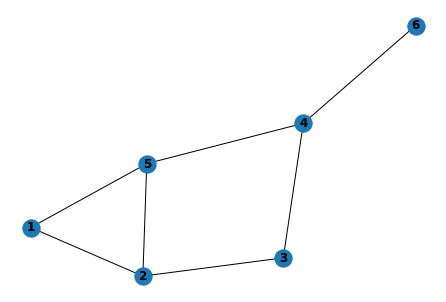

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Refine by Matching output below
G_A edges:  (1, 5)
G_A edges:  (1, 2)
G_A edges:  (2, 3)
G_A edges:  (2, 5)
G_A edges:  (3, 4)
G_A edges:  (4, 5)
G_A edges:  (4, 6)
for edge in E(P_A)
*****************  Mapping Test : 1 --> 2  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i1', 'i3', 'i5']
vertices for Nj: ['j2', 'j5']
xi: ['xi1', 'xi2']
xj: ['xj1']
    Ni Union Nj: {1, 2, 3, 5}
    neighbors of 2: {1, 3, 5}
    intersection: {1, 3, 5}
    Ni Union Nj: {1, 2, 3, 5}
    neighbors of 1: {2, 5}
    intersection: {2, 5}
(1, 2) is in THIRD 3 clause
 degree of 2 = 3
 degree of 1 = 2
    Ni Union Nj: {1, 2, 3, 5}
    neighbors of 5: {1, 2, 4}
    intersection: {1, 2}
    Ni Union Nj: {1, 2, 3, 5}
    neighbors of 1: {2, 5}
    intersection: {2, 5}
(1, 5) is in THIRD 3 clause
 degree of 5 = 3
 degree of 1 = 2
    Ni Union 

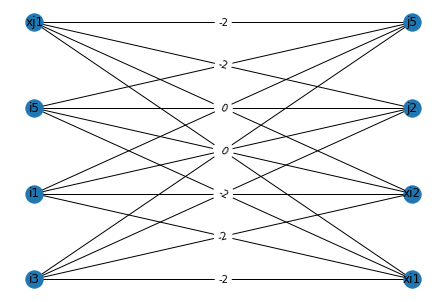

is perfect matching: True
MATCHING: {('i3', 'j2'), ('i5', 'j5'), ('xj1', 'xi2'), ('i1', 'xi1')}
encoded edge: ('i1', 'xi1')
value dict conversion: value[i] = 1, value[j] = 2
cost = 3
deleteEdge = [(1, 2)]
*****************  Mapping Test : 1 --> 3  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i2', 'i5']
vertices for Nj: ['j2', 'j4']
xi: ['xi1']
xj: ['xj1']
    Ni Union Nj: {2, 4, 5}
    neighbors of 2: {1, 3, 5}
    intersection: {5}
(2, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 2 = 3
    Ni Union Nj: {2, 4, 5}
    neighbors of 5: {1, 2, 4}
    intersection: {2, 4}
(5, 2) is in THIRD 3 clause
 degree of 2 = 3
 degree of 5 = 3
    Ni Union Nj: {2, 4, 5}
    neighbors of 5: {1, 2, 4}
    intersection: {2, 4}
(5, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 5 = 3
edge weights
edge: ('i2', 'j2') -- weight: 0


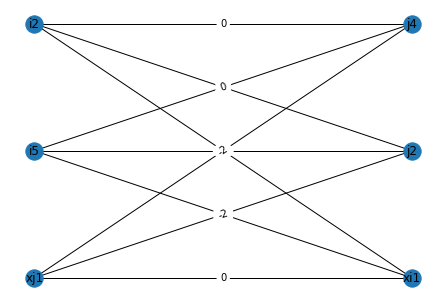

is perfect matching: True
MATCHING: {('xj1', 'xi1'), ('i5', 'j2'), ('i2', 'j4')}
cost = 0
deleteEdge = []
*****************  Mapping Test : 1 --> 4  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i3', 'i5', 'i6']
vertices for Nj: ['j2', 'j5']
xi: ['xi1', 'xi2']
xj: ['xj1']
    Ni Union Nj: {2, 3, 5, 6}
    neighbors of 2: {1, 3, 5}
    intersection: {3, 5}
    Ni Union Nj: {2, 3, 5, 6}
    neighbors of 3: {2, 4}
    intersection: {2}
(3, 2) is in THIRD 3 clause
 degree of 2 = 3
 degree of 3 = 2
    Ni Union Nj: {2, 3, 5, 6}
    neighbors of 5: {1, 2, 4}
    intersection: {2}
    Ni Union Nj: {2, 3, 5, 6}
    neighbors of 3: {2, 4}
    intersection: {2}
(3, 5) is in THIRD 3 clause
 degree of 5 = 3
 degree of 3 = 2
    Ni Union Nj: {2, 3, 5, 6}
    neighbors of 5: {1, 2, 4}
    intersection: {2}
(5, 2) is in THIRD 3 clause
 

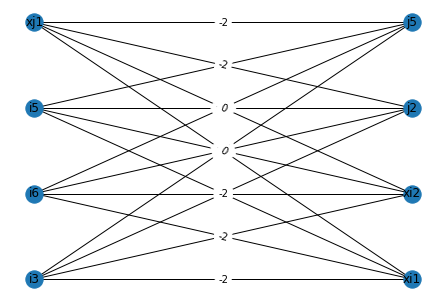

is perfect matching: True
MATCHING: {('i6', 'xi1'), ('i3', 'j2'), ('i5', 'j5'), ('xj1', 'xi2')}
encoded edge: ('i6', 'xi1')
value dict conversion: value[i] = 6, value[j] = 4
cost = 3
deleteEdge = [(6, 4)]
*****************  Mapping Test : 1 --> 5  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i1', 'i2', 'i4']
vertices for Nj: ['j2', 'j5']
xi: ['xi1', 'xi2']
xj: ['xj1']
    Ni Union Nj: {1, 2, 4, 5}
    neighbors of 5: {1, 2, 4}
    intersection: {1, 2, 4}
    Ni Union Nj: {1, 2, 4, 5}
    neighbors of 1: {2, 5}
    intersection: {2, 5}
(1, 5) is in THIRD 3 clause
 degree of 5 = 3
 degree of 1 = 2
    Ni Union Nj: {1, 2, 4, 5}
    neighbors of 2: {1, 3, 5}
    intersection: {1, 5}
(2, 5) is in THIRD 3 clause
 degree of 5 = 3
 degree of 2 = 3
    Ni Union Nj: {1, 2, 4, 5}
    neighbors of 4: {3, 5, 6}
    intersection: {5}
(4, 2) i

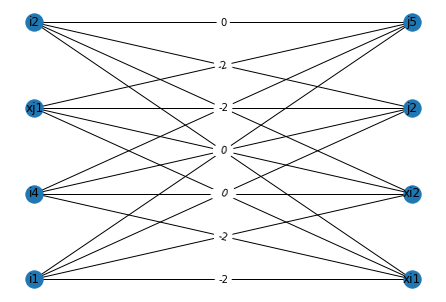

is perfect matching: True
MATCHING: {('xj1', 'xi2'), ('i4', 'j2'), ('i2', 'j5'), ('i1', 'xi1')}
encoded edge: ('i1', 'xi1')
value dict conversion: value[i] = 1, value[j] = 5
cost = 2
deleteEdge = [(1, 5)]
*****************  Mapping Test : 1 --> 6  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i2', 'i5']
vertices for Nj: ['j4']
xi: ['xi1', 'xi2']
xj: ['xj1']
    Ni Union Nj: {2, 4, 5}
    neighbors of 2: {1, 3, 5}
    intersection: {5}
(2, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 2 = 3
    Ni Union Nj: {2, 4, 5}
    neighbors of 5: {1, 2, 4}
    intersection: {2, 4}
(5, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 5 = 3
edge weights
edge: ('i2', 'j4') -- weight: 0
edge: ('i2', 'xi1') -- weight: -2
edge: ('i2', 'xi2') -- weight: -2
edge: ('i5', 'j4') -- weight: 0
edge: ('i5', 'xi1') -- weight: -2
edge: ('i5', 'xi2

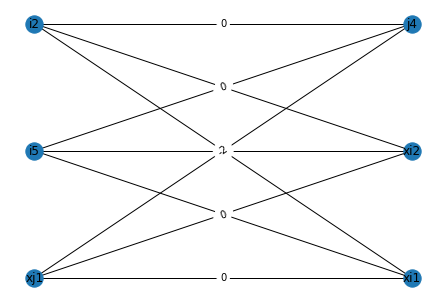

is perfect matching: True
MATCHING: {('i5', 'j4'), ('xj1', 'xi2'), ('i2', 'xi1')}
encoded edge: ('i2', 'xi1')
value dict conversion: value[i] = 2, value[j] = 1
cost = 2
deleteEdge = [(2, 1)]
*****************  Mapping Test : 2 --> 3  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i1', 'i3', 'i5']
vertices for Nj: ['j2', 'j4']
xi: ['xi1', 'xi2']
xj: ['xj1']
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 2: {1, 3, 5}
    intersection: {1, 3, 5}
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 3: {2, 4}
    intersection: {2, 4}
(3, 2) is in THIRD 3 clause
 degree of 2 = 3
 degree of 3 = 2
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 4: {3, 5, 6}
    intersection: {3, 5}
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 3: {2, 4}
    intersection: {2, 4}
(3, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 3 = 2
    Ni Uni

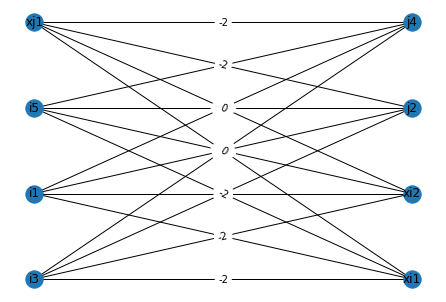

is perfect matching: True
MATCHING: {('i3', 'j2'), ('i5', 'j4'), ('xj1', 'xi2'), ('i1', 'xi1')}
encoded edge: ('i1', 'xi1')
value dict conversion: value[i] = 1, value[j] = 2
cost = 3
deleteEdge = [(1, 2)]
*****************  Mapping Test : 2 --> 4  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i1', 'i3', 'i5']
vertices for Nj: ['j3', 'j5', 'j6']
xi: ['xi1']
xj: ['xj1']
    Ni Union Nj: {1, 3, 5, 6}
    neighbors of 1: {2, 5}
    intersection: {5}
(1, 3) is in THIRD 3 clause
 degree of 3 = 2
 degree of 1 = 2
    Ni Union Nj: {1, 3, 5, 6}
    neighbors of 5: {1, 2, 4}
    intersection: {1}
    Ni Union Nj: {1, 3, 5, 6}
    neighbors of 1: {2, 5}
    intersection: {5}
(1, 5) is in THIRD 3 clause
 degree of 5 = 3
 degree of 1 = 2
    Ni Union Nj: {1, 3, 5, 6}
    neighbors of 1: {2, 5}
    intersection: {5}
    Ni Union Nj: {1, 3, 5, 6}
    n

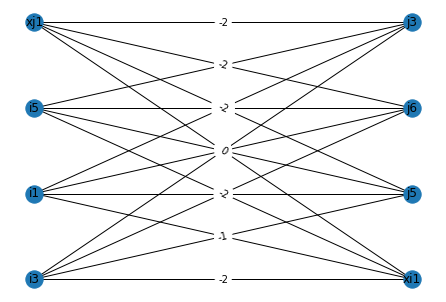

is perfect matching: True
MATCHING: {('i1', 'j6'), ('i5', 'j5'), ('xj1', 'xi1'), ('i3', 'j3')}
cost = 1
deleteEdge = []
*****************  Mapping Test : 2 --> 5  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i1', 'i3', 'i5']
vertices for Nj: ['j1', 'j2', 'j4']
xi: ['xi1']
xj: ['xj1']
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 3: {2, 4}
    intersection: {2, 4}
(3, 1) is in THIRD 3 clause
 degree of 1 = 2
 degree of 3 = 2
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 4: {3, 5, 6}
    intersection: {3, 5}
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 3: {2, 4}
    intersection: {2, 4}
(3, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 3 = 2
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 5: {1, 2, 4}
    intersection: {1, 2, 4}
    Ni Union Nj: {1, 2, 3, 4, 5}
    neighbors of 5: {1, 2, 4}
    intersection: {1, 2, 4}

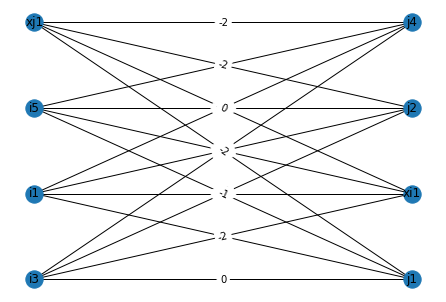

is perfect matching: True
MATCHING: {('i1', 'j1'), ('xj1', 'xi1'), ('i5', 'j2'), ('i3', 'j4')}
cost = 1
deleteEdge = []
*****************  Mapping Test : 3 --> 4  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i3', 'i5', 'i6']
vertices for Nj: ['j2', 'j4']
xi: ['xi1', 'xi2']
xj: ['xj1']
    Ni Union Nj: {2, 3, 4, 5, 6}
    neighbors of 4: {3, 5, 6}
    intersection: {3, 5, 6}
    Ni Union Nj: {2, 3, 4, 5, 6}
    neighbors of 3: {2, 4}
    intersection: {2, 4}
(3, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 3 = 2
    Ni Union Nj: {2, 3, 4, 5, 6}
    neighbors of 5: {1, 2, 4}
    intersection: {2, 4}
(5, 2) is in THIRD 3 clause
 degree of 2 = 3
 degree of 5 = 3
    Ni Union Nj: {2, 3, 4, 5, 6}
    neighbors of 5: {1, 2, 4}
    intersection: {2, 4}
(5, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 5 = 3
edge weights
edge: ('i3'

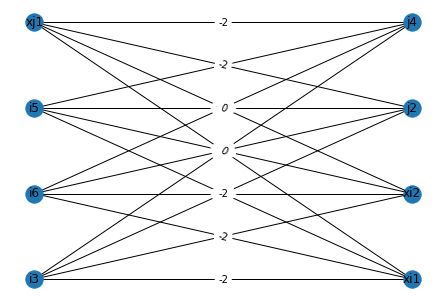

is perfect matching: True
MATCHING: {('i6', 'xi1'), ('xj1', 'xi2'), ('i5', 'j2'), ('i3', 'j4')}
encoded edge: ('i6', 'xi1')
value dict conversion: value[i] = 6, value[j] = 4
cost = 3
deleteEdge = [(6, 4)]
*****************  Mapping Test : 3 --> 5  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i1', 'i2', 'i4']
vertices for Nj: ['j2', 'j4']
xi: ['xi1', 'xi2']
xj: ['xj1']
    Ni Union Nj: {1, 2, 4}
    neighbors of 2: {1, 3, 5}
    intersection: {1}
(2, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 2 = 3
    Ni Union Nj: {1, 2, 4}
    neighbors of 4: {3, 5, 6}
    intersection: set()
(4, 2) is in THIRD 3 clause
 degree of 2 = 3
 degree of 4 = 3
edge weights
edge: ('i1', 'j2') -- weight: -inf
edge: ('i1', 'j4') -- weight: -inf
edge: ('i1', 'xi1') -- weight: -2
edge: ('i1', 'xi2') -- weight: -2
edge: ('i2', 'j2') -- weight: 0
edge: ('i2', 'j4')

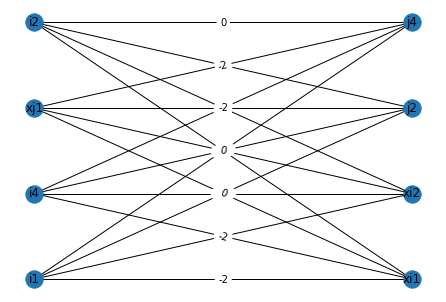

is perfect matching: True
MATCHING: {('xj1', 'xi2'), ('i4', 'j2'), ('i2', 'j4'), ('i1', 'xi1')}
encoded edge: ('i1', 'xi1')
value dict conversion: value[i] = 1, value[j] = 5
cost = 2
deleteEdge = [(1, 5)]
*****************  Mapping Test : 3 --> 6  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i2', 'i4']
vertices for Nj: ['j4']
xi: ['xi1', 'xi2']
xj: ['xj1']
    Ni Union Nj: {2, 4}
    neighbors of 2: {1, 3, 5}
    intersection: set()
(2, 4) is in THIRD 3 clause
 degree of 4 = 3
 degree of 2 = 3
edge weights
edge: ('i2', 'j4') -- weight: 0
edge: ('i2', 'xi1') -- weight: -2
edge: ('i2', 'xi2') -- weight: -2
edge: ('i4', 'j4') -- weight: 0
edge: ('i4', 'xi1') -- weight: -2
edge: ('i4', 'xi2') -- weight: -2
edge: ('j4', 'xj1') -- weight: -2
edge: ('xi1', 'xj1') -- weight: 0
edge: ('xi2', 'xj1') -- weight: 0


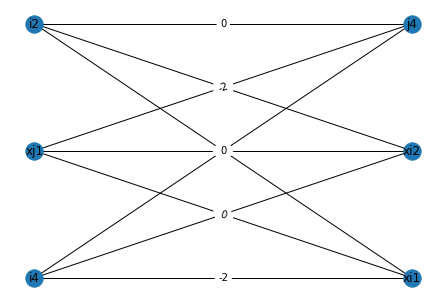

is perfect matching: True
MATCHING: {('i4', 'j4'), ('xj1', 'xi2'), ('i2', 'xi1')}
encoded edge: ('i2', 'xi1')
value dict conversion: value[i] = 2, value[j] = 3
cost = 2
deleteEdge = [(2, 3)]
*****************  Mapping Test : 4 --> 5  *****************
G_A = [(1, 5), (1, 2), (2, 3), (2, 5), (3, 4), (4, 5), (4, 6)]
P_A = [(1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (3, 5), (3, 6), (4, 5)]
Ef_A = []
k_A = 1
vertices for Ni: ['i3', 'i5', 'i6']
vertices for Nj: ['j1', 'j2', 'j4']
xi: ['xi1']
xj: ['xj1']
    Ni Union Nj: {1, 2, 3, 4, 5, 6}
    neighbors of 3: {2, 4}
    intersection: {2, 4}
(3, 1) is in THIRD 3 clause
 degree of 1 = 2
 degree of 3 = 2
    Ni Union Nj: {1, 2, 3, 4, 5, 6}
    neighbors of 5: {1, 2, 4}
    intersection: {1, 2, 4}
    Ni Union Nj: {1, 2, 3, 4, 5, 6}
    neighbors of 5: {1, 2, 4}
    intersection: {1, 2, 4}
(5, 1) is in THIRD 3 clause
 degree of 1 = 2
 degree of 5 = 3
    Ni Union Nj: {1, 2, 3, 4, 5, 6}
    neighbors of 5: {1, 2, 4}
    intersection: {1, 2, 4}
(5, 2)

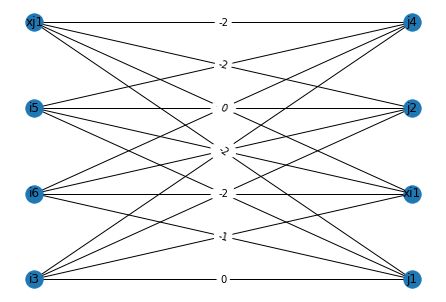

is perfect matching: True
MATCHING: {('i6', 'xi1'), ('i5', 'j4'), ('i3', 'j1'), ('xj1', 'j2')}
encoded edge: ('i6', 'xi1')
value dict conversion: value[i] = 6, value[j] = 4
encoded edge: ('xj1', 'j2')
value dict conversion: value[i] = 5, value[j] = 2
cost = 4
deleteEdge = [(6, 4), (5, 2)]
{(1, 5): 2, (1, 2): 1, (2, 3): 1, (2, 5): 0, (3, 4): 0, (4, 5): 0, (4, 6): 0}
before: [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5)]
after: [(1, 3), (1, 5), (1, 6), (2, 4), (2, 5), (3, 5), (3, 6)]
Refine by Matching output above
 unproven mappings before DegreeDiffElim: 15 

[[0 1 1 1 1 1]
 [1 0 1 1 1 1]
 [1 1 0 1 1 1]
 [1 1 1 0 1 1]
 [1 1 1 1 0 1]
 [1 1 1 1 1 0]]

 unproven mappings after DegreeDiffElim, before RBM: 12 

[[0 1 1 1 1 1]
 [1 0 1 1 1 0]
 [1 1 0 1 1 1]
 [1 1 1 0 1 0]
 [1 1 1 1 0 0]
 [1 0 1 0 0 0]]

 unproven mappings after RBM:  7

[[0 0 1 0 1 1]
 [0 0 0 1 1 0]
 [1 0 0 0 1 1]
 [0 1 0 0 0 0]
 [1 1 1 0 0 0]
 [1 0 1 0 0 0]]


In [14]:
nx.draw(G_A, with_labels=True, font_weight='bold')
plt.show()
#initialize
k_A = 1

b4dde = len(P_A.edges())
b4ddeMat = nx.adjacency_matrix(P_A).todense()
P_A = DegreeDiffElim(G_A,P_A,k_A)
afterdde = len(P_A.edges())
afterddeMat = nx.adjacency_matrix(P_A).todense()
print("Refine by Matching output below")
edgeUse = RefineByMatching(G_A,P_A,Ef_A,k_A)
print("Refine by Matching output above")
print(f" unproven mappings before DegreeDiffElim: {b4dde} \n")
print(np.matrix(b4ddeMat))
print(f"\n unproven mappings after DegreeDiffElim, before RBM: {afterdde} \n")
print(np.matrix(afterddeMat))
print(f"\n unproven mappings after RBM:  {len(P_A.edges())}\n")
print(np.matrix(nx.adjacency_matrix(P_A).todense()))

#
# draw bipartite graph
#
#l,r = bipartite.sets(cm)
#pos = dict()
#pos.update( (nn, (1, ii+ len(l)/2)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
#pos.update( (nn, (2, n*ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
#nx.draw(cm, pos=pos,with_labels=True)

#edge weights
#labels = nx.get_edge_attributes(cm, "weight")
#nx.draw_networkx_edge_labels(cm, pos=pos, edge_labels=labels)
plt.show()

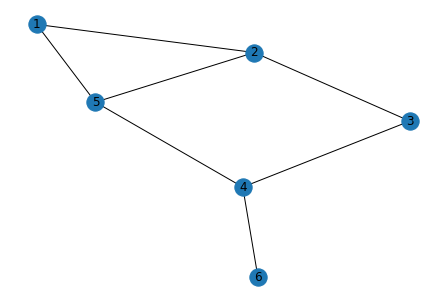

{1, 3, 5}
Neighborhood of 2 is {1, 3, 5}
3
5
1
Neighborhood of 1 is {2, 5}
5
2
------
1
2
3
5
Ni union Nj: {1, 2, 3, 5}
Neighborhood of v: {1, 2, 4}
Intersection of Nv and Ni U Nj: {1, 2}
{1, 2}
False


In [34]:
nx.draw(G_A, with_labels=True,font='bold')
plt.show()

